In [108]:
%matplotlib inline

In [109]:
import numpy as np
import pandas as pd

from sklearn import linear_model, metrics
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import LeaveOneOut

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator

from sklearn_pandas import DataFrameMapper

from scipy.optimize import leastsq
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
from tpot import TPOTClassifier
from sklearn.externals import joblib

In [111]:
file_name = 'ceo.xlsx'

In [112]:
df_origin = pd.read_excel(file_name)

In [113]:
df_origin.head()

,salary,totcomp,tenure,age,sales,profits,assets,Unnamed: 7
0,3030,8138,7,61,161315.0,2956.0,257389.0,NaN
1,6050,14530,0,51,144416.0,22071.0,237545.0,NaN
2,3571,7433,11,63,139208.0,4430.0,49271.0,NaN
3,3300,13464,6,60,100697.0,6370.0,92630.0,NaN
4,10000,68285,18,63,100469.0,9296.0,355935.0,NaN


In [114]:
df = df_origin.drop(['Unnamed: 7'], axis=1)

In [115]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,8138,7,61,161315.0,2956.0,257389.0
1,6050,14530,0,51,144416.0,22071.0,237545.0
2,3571,7433,11,63,139208.0,4430.0,49271.0
3,3300,13464,6,60,100697.0,6370.0,92630.0
4,10000,68285,18,63,100469.0,9296.0,355935.0


In [116]:
df["salary"].describe()

count      447.000000
mean      2027.516779
std       1722.566389
min        100.000000
25%       1084.000000
50%       1600.000000
75%       2347.500000
max      15250.000000
Name: salary, dtype: float64

In [117]:
# let's look at the data types
df.dtypes

salary       int64
totcomp      int64
tenure       int64
age          int64
sales      float64
profits    float64
assets     float64
dtype: object

In [118]:
# Let's compute the number of missing values
pd.isnull(df).sum()

salary     0
totcomp    0
tenure     0
age        0
sales      0
profits    0
assets     0
dtype: int64

In [119]:
#dependent variable
target = "salary"

# remaining variables  -features
features = list(df.columns.values)
features.remove(target)

In [120]:
features

[u'totcomp', u'tenure', u'age', u'sales', u'profits', u'assets']

In [121]:
# Standardization
std_scale =  preprocessing.StandardScaler().fit(df[features])
df_features = std_scale.transform(df[features])

In [122]:
df[features] = df_features

In [123]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083


In [124]:
X = df[features]
y = df[target]

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### (c) Run a lasso regression for scaled  data with alpha (0; 1).

In [126]:
alpha = 0.8

In [127]:
lassoreg = Lasso(alpha=alpha)

In [128]:
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)

In [129]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [130]:
mean_absolute_percentage_error(y_test, y_pred)

47.659306806261128

In [131]:
lassoreg.coef_

array([ 416.40645107,  256.68105787,   56.78303056,  323.2845075 ,
         -1.02785237,  489.2021878 ])

In [132]:
coef = lassoreg.coef_
print "y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}*x3 + {:.2f}*x4 + {:.2f}*x5 + {:.2f}*x6".format(coef[0], coef[1], coef[2], coef[3], coef[4], coef[5])

y = 416.41*x1 + 256.68*x2 + 56.78*x3 + 323.28*x4 + -1.03*x5 + 489.20*x6


In [133]:
# Plot the estimated parameters as functions of alpha.

In [134]:
n_alphas = 200
alphas = np.logspace(-4, 0, n_alphas)

coefs = []
for a in alphas:
    lr = Lasso(alpha=a)
    lr.fit(X_train, y_train)
    coefs.append(lr.coef_)

In [135]:
coefs = np.vstack(coefs)

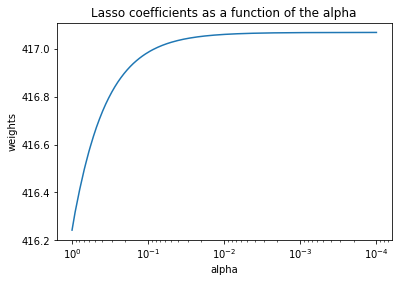

In [136]:
# Display results

ax = plt.gca()

ax.plot(alphas, coefs[:,0])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the alpha')
plt.axis('tight')
plt.show()

In [137]:
# Which value of alpha would you recommend?

In [138]:
scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better = True)

In [139]:
lassocv = linear_model.LassoCV(alphas=alphas, normalize=True)
lassocv.fit(X_train, y_train)
lassocv_score = lassocv.score(X_test, y_test)
lassocv_alpha = lassocv.alpha_

In [140]:
lassocv_alpha

1.0

In [141]:
# another approach

In [142]:
tuned_parameters = {'alpha': np.logspace(-10, 0, 5)}
lasso = GridSearchCV(estimator=linear_model.Lasso(),param_grid=tuned_parameters)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
mape = mean_absolute_percentage_error(y_test, lasso_preds)
print 'Lasso mape: {}'.format(mape)

Lasso mape: 47.6555064096


In [143]:
lasso.best_estimator_.alpha

1.0

In [144]:
df_profits_sales = df_origin[df_origin['profits'] >= 0]

In [145]:
log_profits = np.array(np.log(df_profits_sales['profits'].values))
log_sales = np.array(np.log(df_profits_sales['sales'].values))

In [146]:
type(log_sales)

numpy.ndarray

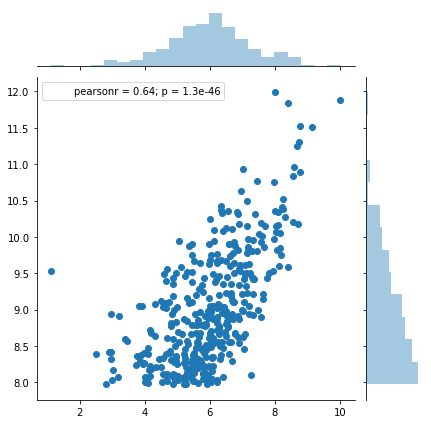

In [147]:
# (a) Make a bivariate scatter plot
sns.jointplot(x=log_profits, y=log_sales)

In [148]:
# Create linear regression object
lregr = linear_model.LinearRegression()

In [149]:
# Train the model using the training sets
lregr.fit(log_sales.reshape(-1, 1), log_profits)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
# Make predictions using the testing set
lregr_y_pred = lregr.predict(log_sales.reshape(-1, 1))

In [151]:
# The intercept
print('Intercept: ', lregr.intercept_)

('Intercept: ', -3.1210892992114498)


In [152]:
# The coefficients
print('Coefficients: ', lregr.coef_)

('Coefficients: ', array([ 1.01099621]))


In [153]:
# The mean squared error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, lregr_y_pred))

mean absolute percentage_error: 15.12


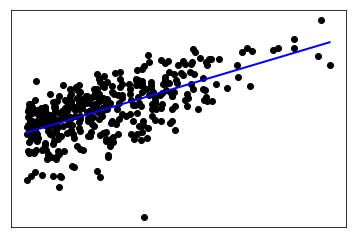

In [154]:
# Plot outputs
plt.scatter(log_sales.reshape(-1, 1), log_profits,  color='black')
plt.plot(log_sales.reshape(-1, 1), lregr_y_pred, color='blue', linewidth=2)

plt.xticks(())
plt.yticks(())

plt.show()

In [155]:
def func(x, intercept, coeff, power):
    return intercept + coeff * pow(x, power)

popt, pcov = curve_fit(func, log_sales, log_profits, p0=(0.0, 1.0, 2.0))

In [156]:
# the fit parameters
popt

array([ 1.11153934,  0.0890415 ,  1.81832607])

In [157]:
pcov

array([[ 8.74805335, -0.75632962,  3.03321528],
       [-0.75632962,  0.06581633, -0.26439227],
       [ 3.03321528, -0.26439227,  1.06256632]])

In [158]:
func_pred = func(log_sales, popt[0], popt[1], popt[2])

In [159]:
# The mean squared error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, func_pred))

mean absolute percentage_error: 15.11


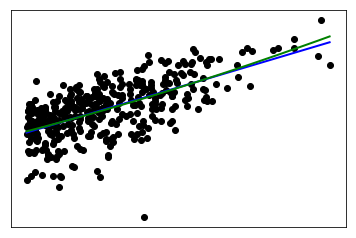

In [160]:
# Plot outputs
plt.scatter(log_sales.reshape(-1, 1), log_profits,  color='black')
plt.plot(log_sales.reshape(-1, 1), lregr_y_pred, color='blue', linewidth=2)
plt.plot(log_sales.reshape(-1, 1), func_pred, color='green', linewidth=2)
plt.xticks(())
plt.yticks(())

plt.show()

#### 3. Next we model the relationship between log-profits and log-sales using a nonparametric regression.

In [161]:
class KernelRegression(BaseEstimator, RegressorMixin):

    # Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
    #
    # License: BSD 3 clause
    # https://github.com/jmetzen/kernel_regression

    """Nadaraya-Watson kernel regression with automatic bandwidth selection.
    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.
    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.
    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.
    See also
    --------
    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values
        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [162]:
gamma=np.logspace(-2, 2, 10)
param_grid={"C": [1e-1, 1e0, 1e1, 1e2], "gamma": gamma}

In [163]:
# Fit regression models
svr = GridSearchCV(SVR(kernel='rbf'), cv=5, param_grid = param_grid)
nadaraya_watson = KernelRegression(kernel="rbf", gamma=gamma)

In [164]:
svr_pred = svr.fit(log_sales.reshape(-1, 1), log_profits).predict(log_sales.reshape(-1, 1))

In [165]:
nadaraya_watson_pred = nadaraya_watson.fit(log_sales.reshape(-1, 1), log_profits).predict(log_sales.reshape(-1, 1))

In [166]:
# svr error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, svr_pred))

mean absolute percentage_error: 15.21


In [167]:
# nadaraya_watson error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, nadaraya_watson_pred))

mean absolute percentage_error: 14.95


#### 4. We manually classify all CEO into those who earn more than 2000 and those who earn less than 2000.

In [168]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083


In [169]:
df['Ygr2000'] = np.where(df['salary']>2000, 1, 0)

In [170]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets,Ygr2000
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288,1
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042,1
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983,1
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313,1
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083,1


In [171]:
labels = df['Ygr2000']

In [172]:
variables = df[features]

In [173]:
X_train, X_test, y_train, y_test = train_test_split(variables, labels,
                                                    train_size=0.75, test_size=0.25)

In [174]:
cv = 5

In [175]:
estimator = LogisticRegression()

In [176]:
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'penalty': ['l1']
}

In [177]:
optimizer = GridSearchCV(estimator, param_grid, cv = cv)

In [178]:
optimizer.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [179]:
auc_2 = roc_auc_score(y_test, optimizer.predict(X_test))

In [180]:
auc_2

0.63095238095238093

In [181]:
print('Intercept:', optimizer.best_estimator_.intercept_[0])

('Intercept:', -0.38202222985712192)


In [182]:
print('Coefficient of each feature:', optimizer.best_estimator_.coef_)

('Coefficient of each feature:', array([[ 2.02367094,  0.23781973,  0.12889213,  0.52425205,  0.87031704,
         0.5015602 ]]))


In [183]:
print(pd.DataFrame(np.transpose(optimizer.best_estimator_.coef_),df[features].columns))

                0
totcomp  2.023671
tenure   0.237820
age      0.128892
sales    0.524252
profits  0.870317
assets   0.501560


In [184]:
# another approach
lregrcv = LogisticRegressionCV(cv=10, penalty='l1', solver='liblinear')

In [185]:
lregrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [186]:
auc_2 = roc_auc_score(y_test, lregrcv.predict(X_test))

In [187]:
auc_2

0.63095238095238093

In [188]:
print('Intercept:', lregrcv.intercept_[0])

('Intercept:', -0.34120045060586107)


In [189]:
print('Coefficient of each feature:', lregrcv.coef_)

('Coefficient of each feature:', array([[ 2.63891287,  0.25905291,  0.16383598,  0.57453385,  0.93652274,
         0.55451406]]))


In [190]:
print(pd.DataFrame(np.transpose(lregrcv.coef_),df[features].columns))

                0
totcomp  2.638913
tenure   0.259053
age      0.163836
sales    0.574534
profits  0.936523
assets   0.554514


In [191]:
# after l1 regularization we have all non-zero coefficients. so - keep them all

In [192]:
np.random.seed(3)

# number of rows
remove_n = 5

# pick up random CEO from test and get it's indices
randCEO_indices = np.random.choice(X_test.index, remove_n, replace=False)
randCEO_indices

array([204,  39, 156,  32, 106], dtype=int64)

In [193]:
# actual class
y_test.loc[randCEO_indices]

204    1
39     0
156    1
32     1
106    0
Name: Ygr2000, dtype: int32

In [194]:
# predicted class
optimizer.predict(X_test.loc[randCEO_indices]).reshape(-1,1)

array([[1],
       [0],
       [1],
       [1],
       [0]])

In [195]:
# Determine their probabilities of having the salary of less , or more  than 2000:
optimizer.predict_proba(X_test.loc[randCEO_indices])

array([[  4.64901415e-01,   5.35098585e-01],
       [  6.53279373e-01,   3.46720627e-01],
       [  1.54647648e-02,   9.84535235e-01],
       [  4.65575659e-05,   9.99953442e-01],
       [  7.37338813e-01,   2.62661187e-01]])

In [196]:
# * first column is the probability that CEO has less than 2000

In [197]:
#Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [198]:
print(classification_report(y_test, optimizer.predict(X_test)))

             precision    recall  f1-score   support

          0       0.81      0.87      0.84        84
          1       0.50      0.39      0.44        28

avg / total       0.73      0.75      0.74       112



In [199]:
print(classification_report(y_test, lregrcv.predict(X_test)))

             precision    recall  f1-score   support

          0       0.81      0.87      0.84        84
          1       0.50      0.39      0.44        28

avg / total       0.73      0.75      0.74       112



In [200]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, optimizer.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

In [201]:
thresholds

array([2, 1, 0])

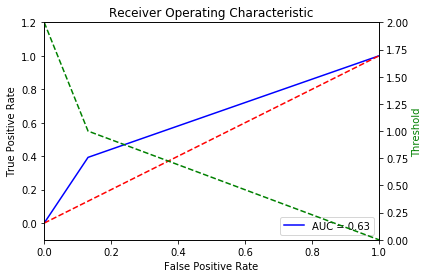

In [202]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(false_positive_rate, thresholds, markeredgecolor='g',linestyle='dashed', color='g')
ax2.set_ylabel('Threshold',color='g')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([false_positive_rate[0],false_positive_rate[-1]])
plt.show()

In [203]:
# as I known, python does not have function like coords for best treshold

#### 5. In the next step we model the salary of CEOs using regression trees.

In [204]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 12],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

dt_estimator = DecisionTreeClassifier()
dt_opt = GridSearchCV(estimator=dt_estimator, param_grid=param_grid, cv = cv)

In [205]:
dt_opt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 10, 12], 'max_leaf_nodes': [None, 5, 10, 20], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [206]:
tree_model = dt_opt.best_estimator_
print (dt_opt.best_score_, dt_opt.best_params_)

(0.77014925373134324, {'min_samples_split': 10, 'max_leaf_nodes': 10, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10})


In [207]:
roc_auc_score(y_test, tree_model.predict(X_test))

0.73214285714285721

In [208]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, tree_model.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

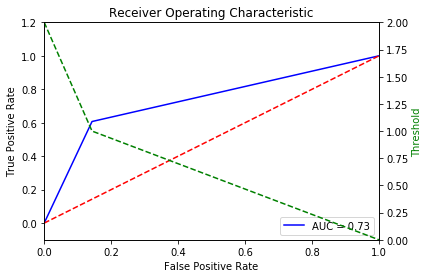

In [209]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(false_positive_rate, thresholds, markeredgecolor='g',linestyle='dashed', color='g')
ax2.set_ylabel('Threshold',color='g')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([false_positive_rate[0],false_positive_rate[-1]])
plt.show()

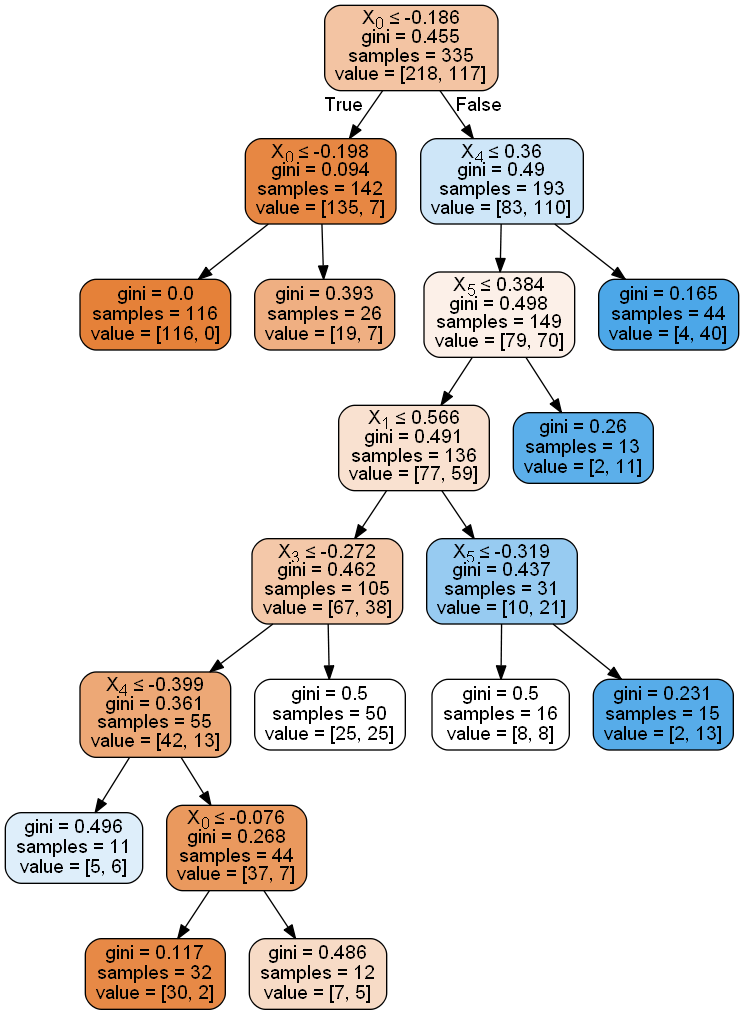

In [210]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [211]:
# Another approach
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=BernoulliNB(alpha=100.0, fit_prior=True)),
    DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=15, min_samples_split=5)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [212]:
roc_auc_score(y_test, exported_pipeline.predict(X_test))

0.70238095238095233

In [213]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, exported_pipeline.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)

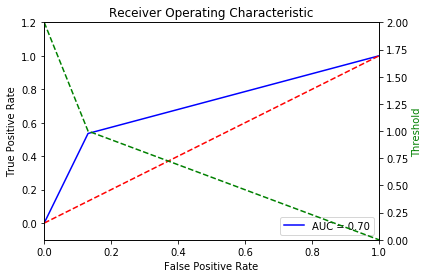

In [214]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(false_positive_rate, thresholds, markeredgecolor='g',linestyle='dashed', color='g')
ax2.set_ylabel('Threshold',color='g')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([false_positive_rate[0],false_positive_rate[-1]])
plt.show()